# Catboost predictor - Frequency encoded
Implemented version of the catboost model predictor model with one-hot encoding

In [1]:
# import basic libraries
import pandas as pd

# import machine learning libraries
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#import catboost
from catboost import CatBoostRegressor

In [45]:
#import the data
X_train = pd.read_csv("data/generated/frequency/X_train.csv")
y_train = pd.read_csv("data/generated/frequency/y_train.csv")
X_test = pd.read_csv("data/generated/frequency/X_test.csv")
y_test = pd.read_csv("data/generated/frequency/y_test.csv")
X_test.head(3)

,Unnamed: 0,org:resource,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:ApplicationType,case:concept:name,case:RequestedAmount,FirstWithdrawalAmount,...,case:LoanGoal_Debt restructuring,case:LoanGoal_Existing loan takeover,case:LoanGoal_Extra spending limit,case:LoanGoal_Home improvement,case:LoanGoal_Motorcycle,case:LoanGoal_Not speficied,"case:LoanGoal_Other, see explanation",case:LoanGoal_Remaining debt home,case:LoanGoal_Tax payments,case:LoanGoal_Unknown
0,1093289,User_1,Application,Application_1000386745,complete,2016-11-25 14:31:09.852000+00:00,New credit,Application_1000386745,5000.0,NaN,...,0,0,0,0,0,0,0,0,0,0
1,1093290,User_1,Application,ApplState_508603983,complete,2016-11-25 14:31:11.088000+00:00,New credit,Application_1000386745,5000.0,NaN,...,0,0,0,0,0,0,0,0,0,0
2,1093291,User_1,Workflow,Workitem_1662375286,schedule,2016-11-25 14:31:11.309000+00:00,New credit,Application_1000386745,5000.0,NaN,...,0,0,0,0,0,0,0,0,0,0


### Pre-process the data

In [46]:
y_test = y_test['remaining_time']
y_train = y_train['remaining_time']

In [47]:
missing_columns = set(X_train.columns) - set(X_test.columns)
print("Missing columns:", missing_columns)

Missing columns: {'concept:name_W_Personal Loan collection', 'concept:name_W_Shortened completion '}


In [48]:
columns_2_drop= ['Unnamed: 0', 'EventID',
        'time:timestamp',
       'case:concept:name', 'Selected']

In [51]:
# Drop the unnamed and lifecycle columns column
X_test = X_test.drop(columns_2_drop, axis=1)
X_train = X_train.drop(columns_2_drop + list(missing_columns), axis=1)

In [52]:
# Separate categorical and numeric features

categorical_features = ['org:resource', 
                  'EventOrigin',
                  'lifecycle:transition', 
                  'case:ApplicationType']
numeric_features = X_train.columns.difference(categorical_features)

# Convert categorical features to string
X_train[categorical_features] = X_train[categorical_features].astype(str)
X_test[categorical_features] = X_test[categorical_features].astype(str)

KeyError: "['concept:name_W_Personal Loan collection', 'concept:name_W_Shortened completion '] not in index"

In [53]:
X_test.dtypes

org:resource                              object
EventOrigin                               object
lifecycle:transition                      object
case:ApplicationType                      object
case:RequestedAmount                     float64
FirstWithdrawalAmount                    float64
NumberOfTerms                            float64
MonthlyCost                              float64
CreditScore                              float64
OfferedAmount                            float64
event_index_in_trace                       int64
execution_time                           float64
Action_Created                             int64
Action_Deleted                             int64
Action_Obtained                            int64
Action_Released                            int64
Action_statechange                         int64
concept:name_A_Accepted                    int64
concept:name_A_Cancelled                   int64
concept:name_A_Complete                    int64
concept:name_A_Conce

### Building the model

In [66]:
# Create a CatBoost regressor
model = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.01, loss_function='RMSE')

In [67]:
# Train the model
model.fit(X_train, y_train, 
          cat_features=categorical_features, 
          eval_set=(X_test, y_test),
          early_stopping_rounds=10, verbose=10)

0:	learn: 13.4748256	test: 11.9209967	best: 11.9209967 (0)	total: 228ms	remaining: 1m 53s
10:	learn: 13.0548479	test: 11.4877568	best: 11.4877568 (10)	total: 1.67s	remaining: 1m 14s
20:	learn: 12.6988025	test: 11.1234571	best: 11.1234571 (20)	total: 2.79s	remaining: 1m 3s
30:	learn: 12.3995193	test: 10.8166233	best: 10.8166233 (30)	total: 4.19s	remaining: 1m 3s
40:	learn: 12.1495642	test: 10.5602097	best: 10.5602097 (40)	total: 5.8s	remaining: 1m 4s
50:	learn: 11.9383715	test: 10.3487055	best: 10.3487055 (50)	total: 7.11s	remaining: 1m 2s
60:	learn: 11.7619893	test: 10.1709278	best: 10.1709278 (60)	total: 8.46s	remaining: 1m
70:	learn: 11.6145746	test: 10.0267356	best: 10.0267356 (70)	total: 10s	remaining: 1m
80:	learn: 11.4908738	test: 9.9058497	best: 9.9058497 (80)	total: 11.9s	remaining: 1m 1s
90:	learn: 11.3870932	test: 9.8068368	best: 9.8068368 (90)	total: 13.6s	remaining: 1m
100:	learn: 11.2979827	test: 9.7220288	best: 9.7220288 (100)	total: 15.1s	remaining: 59.7s
110:	learn: 11.

In [68]:
# Make predictions on the test set
y_pred = model.predict(X_test)

### Evaluate the model

In [69]:
# MSE
mean_squared_error(y_test, y_pred)

86.17731006320633

In [70]:
# R2
r2_score(y_test, y_pred)

0.3953091322223439

### Feature importance

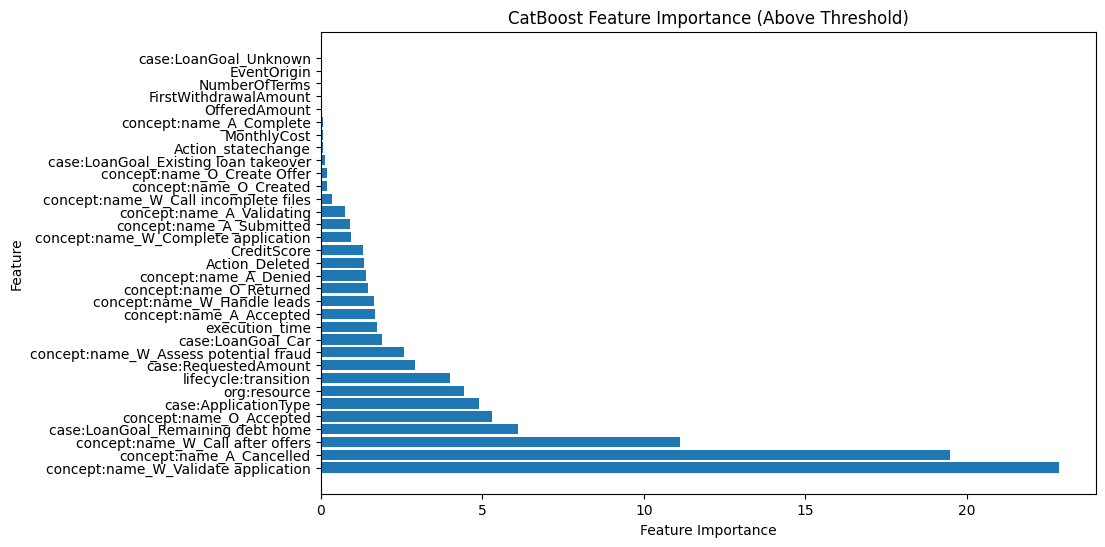

In [71]:
import matplotlib.pyplot as plt

# Assuming 'model' is your trained CatBoostRegressor
feature_importance = model.get_feature_importance()

# Get feature names from the original DataFrame (X_train)
feature_names = X_train.columns

# Create a DataFrame to store feature importance values with their corresponding names
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Set the threshold for visibility
threshold = 0.01  # Adjust this threshold as needed

# Filter features based on the threshold
important_features = feature_importance_df[feature_importance_df['Importance'] >= threshold]

# Sort the DataFrame by importance in descending order
important_features = important_features.sort_values(by='Importance', ascending=False)

# Plot feature importance for only the relevant features
plt.figure(figsize=(10, 6))
plt.barh(important_features['Feature'], important_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('CatBoost Feature Importance (Above Threshold)')
plt.show()
